# Text classification with an RNN

## Setup

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6G8WYU/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6G8WYU/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6G8WYU/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Some common arguments:

split=: Which split to read (e.g. 'train', ['train', 'test'], 'train[80%:]',...). See our split API guide.

shuffle_files=: Control whether to shuffle the files between each epoch (TFDS store big datasets in multiple smaller files).

data_dir=: Location where the dataset is saved ( defaults to ~/tensorflow_datasets/)

with_info=True: Returns the tfds.core.DatasetInfo containing dataset metadata

download=False: Disable download

Initially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

buffer_size: A tf.int64 scalar tf.Tensor, representing the maximum number elements that will be buffered when prefetching.

Shuffling begins by making a buffer of size BUFFER_SIZE (which starts empty but has enough room to store that many elements). 

The buffer is then filled until it has no more capacity with elements from the dataset, then an element is chosen uniformly at random.

This means that each example in the buffer is equally likely to be chosen, with probability 1/BUFFER_SIZE. 

Then, a new example is loaded to fill the slot in the buffer that was emptied. This continues until there is nothing left to load.

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. 

In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. 

The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime.


while the training step is running for sample 0, the input pipeline is reading the data for the sample 1, and so on.

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I watched part one two days ago and today I saw part two. Of course the two parts are worlds apart so I am a little shaken by all that I just saw. I felt consumed by the knowledge of the inevitability of Che's death; for me, it clouded the entire movie. I suppose that is exactly what Soderbergh wanted us to feel, the slowly evolving inevitability of his death. Part Two was so downbeat compared to, again an inevitability but in Cuba it was positive and in Bolivia it was so negative. The politics of the movement in Bolivia were only alluded to but rarely confronted didactically. For me the memorable scenes were all at the end of the film: the confrontation with the jailer and the milder talk with the Bolivian official where that official questions Che about the failure of the peasants to support his revolution. I had not considered the national differences playing as much role as they did in the conflict, Argentine versus Bolivian. I thought Soderbergh dealt admirably with the

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

This layer has basic options for managing text in a Keras model. It transforms a batch of strings (one sample = one string) into either a list of token indices (one sample = 1D tensor of integer token indices) or a dense representation (one sample = 1D tensor of float values representing data about the sample's tokens).

If desired, the user can call this layer's adapt() method on a dataset. When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a 'vocabulary' from them. This vocabulary can have unlimited size or be capped, depending on the configuration options for this layer; if there are more unique values in the input than the maximum vocabulary size, the most frequent terms will be used to create the vocabulary.

The processing of each sample contains the following steps:

standardize each sample (usually lowercasing + punctuation stripping)

split each sample into substrings (usually words)

recombine substrings into tokens (usually ngrams)

index tokens (associate a unique int value with each token)

transform each sample using this index, either into a vector of ints or a dense float vector.

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

max_tokens = The maximum size of the vocabulary for this layer. If None, there is no cap on the size of the vocabulary

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 284, 171, ...,   0,   0,   0],
       [  1,   7, 124, ...,   0,   0,   0],
       [ 11,  14,   1, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

'lower_and_strip_punctuation' (lowercase and remove punctuation) .Default is 'lower_and_strip_punctuation'.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I watched part one two days ago and today I saw part two. Of course the two parts are worlds apart so I am a little shaken by all that I just saw. I felt consumed by the knowledge of the inevitability of Che's death; for me, it clouded the entire movie. I suppose that is exactly what Soderbergh wanted us to feel, the slowly evolving inevitability of his death. Part Two was so downbeat compared to, again an inevitability but in Cuba it was positive and in Bolivia it was so negative. The politics of the movement in Bolivia were only alluded to but rarely confronted didactically. For me the memorable scenes were all at the end of the film: the confrontation with the jailer and the milder talk with the Bolivian official where that official questions Che about the failure of the peasants to support his revolution. I had not considered the national differences playing as much role as they did in the conflict, Argentine versus Bolivian. I thought Soderbergh dealt admirably with t

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

Masking is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data.

Padding is a special form of masking where the masked steps are at the start or the end of a sequence. Padding comes from the need to encode sequence data into contiguous batches: in order to make all sequences in a batch fit a given standard length, it is necessary to pad or truncate some sequences.

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.01419534]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.01419534]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 107s 251ms/step - loss: 0.6292 - accuracy: 0.5946 - val_loss: 0.4845 - val_accuracy: 0.7406
Epoch 2/10
391/391 [==============================] - 95s 242ms/step - loss: 0.3953 - accuracy: 0.8212 - val_loss: 0.3588 - val_accuracy: 0.8297
Epoch 3/10
391/391 [==============================] - 96s 243ms/step - loss: 0.3381 - accuracy: 0.8518 - val_loss: 0.3374 - val_accuracy: 0.8536
Epoch 4/10
391/391 [==============================] - 94s 238ms/step - loss: 0.3228 - accuracy: 0.8590 - val_loss: 0.3279 - val_accuracy: 0.8547
Epoch 5/10
391/391 [==============================] - 94s 238ms/step - loss: 0.3150 - accuracy: 0.8638 - val_loss: 0.3338 - val_accuracy: 0.8417
Epoch 6/10
391/391 [==============================] - 94s 239ms/step - loss: 0.3106 - accuracy: 0.8662 - val_loss: 0.3261 - val_accuracy: 0.8578
Epoch 7/10
391/391 [==============================] - 98s 248ms/step - loss: 0.3078 - accuracy: 0.8672 - val_loss: 0.3332 - val_a

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 48s 123ms/step - loss: 0.3161 - accuracy: 0.8617
Test Loss: 0.3161281943321228
Test Accuracy: 0.8616799712181091


(0.0, 0.6455439627170563)

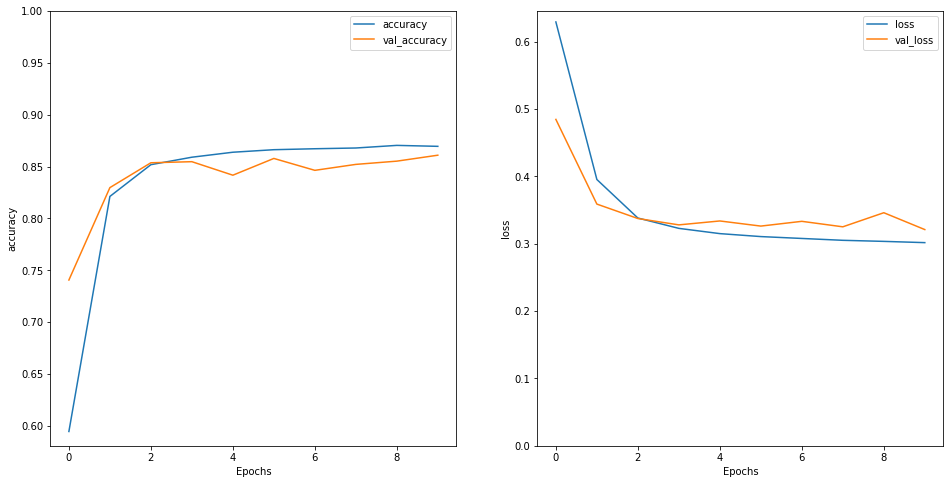

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 202s 465ms/step - loss: 0.6002 - accuracy: 0.6116 - val_loss: 0.4007 - val_accuracy: 0.8156
Epoch 2/10
391/391 [==============================] - 176s 447ms/step - loss: 0.3712 - accuracy: 0.8376 - val_loss: 0.3478 - val_accuracy: 0.8510
Epoch 3/10
391/391 [==============================] - 169s 431ms/step - loss: 0.3302 - accuracy: 0.8571 - val_loss: 0.3373 - val_accuracy: 0.8516
Epoch 4/10
391/391 [==============================] - 169s 432ms/step - loss: 0.3206 - accuracy: 0.8632 - val_loss: 0.3256 - val_accuracy: 0.8547
Epoch 5/10
391/391 [==============================] - 171s 435ms/step - loss: 0.3079 - accuracy: 0.8658 - val_loss: 0.3244 - val_accuracy: 0.8568
Epoch 6/10
391/391 [==============================] - 170s 432ms/step - loss: 0.3042 - accuracy: 0.8690 - val_loss: 0.3317 - val_accuracy: 0.8599
Epoch 7/10
391/391 [==============================] - 172s 437ms/step - loss: 0.3003 - accuracy: 0.8708 - val_loss: 0.3520 -

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

 44/391 [==>...........................] - ETA: 1:12 - loss: 0.3333 - accuracy: 0.8626

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')